In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
import lightgbm as lgb
import glob

import gc

In [2]:
#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [3]:
n_pred = 20 # sessionごとに予測するaidの数（固定）
weight = {"clicks": 0.1, "carts": 0.3, "orders": 0.6}

list_event_type = ["clicks", "carts", "orders"]

path_input_feat = {}
path_input_label = {}
for i in ["train1"]:
    path_input_feat[i] = f"/kaggle/input/otto-make-data-feature/feature_label_{i}_{{}}_{{}}.pickle"
    path_input_label[i] = {}
    for event_type in list_event_type:
        path_input_label[i][event_type] = f"/kaggle/input/otto-make-data-feature/n_ground_truth_{i}_{event_type}.csv"

In [4]:
list_files = glob.glob(path_input_feat["train1"].format('feat','*'))
len(list_files)

45

In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
rand = 64

n_splits = 5
n_round = 1000

lgb_params = {
    "objective": "binary",
    "boosting": "gbdt",
    "max_depth": -1,
    "num_leaves": 700,
    "subsample": 0.8,
    "subsample_freq": 1,
    "bagging_seed": rand,
    "learning_rate": 0.1,
    "feature_fraction": 0.6,
    "min_data_in_leaf": 100,
    "lambda_l1": 0,
    "lambda_l2": 0,
    "random_state": rand,
#     "metric": "average_precision",
    "metric": "binary_logloss",
    "verbose": -1
}

# train

In [7]:
# データ読み込み
df_Xy = []
n_label = {"clicks": 0, "carts": 0, "orders": 0}
w = {"clicks": 1, "carts": 13, "orders": 15}
for n_chunk in range(len(list_files)):
    feat = pd.read_pickle(path_input_feat["train1"].format("feat", n_chunk))
    label = []
    weight_ch = np.ones(len(feat))
    for event_type in list_event_type:
        label_type = pd.read_pickle(path_input_feat["train1"].format(event_type, n_chunk))
        n_label[event_type] += label_type.sum()
        label.append(label_type)
        weight_ch = [x+y for x,y in zip(weight_ch, label_type.tolist() * w[event_type])]
    label = pd.concat(label, axis = 1)    
    label = label.any(axis = 1).astype(int)
    label.name = "label"    
    df_Xy.append(pd.concat([feat,label, pd.Series(weight_ch, name = "weight")], axis = 1))
    
df_Xy = pd.concat(df_Xy)
df_Xy["elapsed_time"] = df_Xy["elapsed_time"].astype(int)
display(n_label)
# df_Xy = df_Xy.drop(["elapsed_time"], axis = 1)
    
df_Xy = reduce_mem_usage(df_Xy)
display(df_Xy.columns)
display(df_Xy.head(50))
df_X = df_Xy.drop(["session", f"label"], axis = 1)
df_y = df_Xy[f"label"]
df_session = df_Xy["session"]

display(df_y.value_counts())

del df_Xy, feat, label
gc.collect()

{'clicks': 1858428, 'carts': 265296, 'orders': 237708}

Mem. usage decreased to 2778.49 Mb (10.4% reduction)


Index(['session', 'n_type_all', 'n_type_clicks', 'n_type_carts',
       'n_type_orders', 'rate_type_clicks', 'rate_type_carts',
       'rate_type_orders', 'n_type_all_aid', 'n_type_clicks_aid',
       'n_type_carts_aid', 'n_type_orders_aid', 'is_last_clicks',
       'is_last_carts', 'is_last_orders', 'num_type_rev', 'elapsed_time',
       'imf_score_clicks', 'bpr_score_clicksxcarts', 'rank_clicks_after_ses',
       'rank_carts_after_ses', 'rank_orders_after_ses', 'last_ts',
       'ses_clicks2clicks', 'ses_clicks2carts', 'ses_clicks2orders',
       'ses_carts2clicks', 'ses_carts2carts', 'ses_carts2orders',
       'ses_orders2clicks', 'ses_orders2carts', 'ses_orders2orders',
       'n_alltypes_0-2', 'n_alltypes_3-5', 'n_alltypes_6-8', 'n_alltypes_9-11',
       'n_alltypes_12-14', 'n_alltypes_15-17', 'n_alltypes_18-20',
       'n_alltypes_21-23', 'past_clicks', 'past_carts', 'past_orders',
       'imf_clicks', 'bpr_clicksxcarts', 'popularity_carts_after',
       'n_clicks_allses', 'n_car

,session,n_type_all,n_type_clicks,n_type_carts,n_type_orders,rate_type_clicks,rate_type_carts,rate_type_orders,n_type_all_aid,n_type_clicks_aid,n_type_carts_aid,n_type_orders_aid,is_last_clicks,is_last_carts,is_last_orders,num_type_rev,elapsed_time,imf_score_clicks,bpr_score_clicksxcarts,rank_clicks_after_ses,rank_carts_after_ses,rank_orders_after_ses,last_ts,ses_clicks2clicks,ses_clicks2carts,...,n_carts2carts_allses,n_carts2orders_allses,n_orders2clicks_allses,n_orders2carts_allses,n_orders2orders_allses,n_clicks2clicks_allses_lastweek,n_clicks2carts_allses_lastweek,n_clicks2orders_allses_lastweek,n_carts2clicks_allses_lastweek,n_carts2carts_allses_lastweek,n_carts2orders_allses_lastweek,n_orders2clicks_allses_lastweek,n_orders2carts_allses_lastweek,n_orders2orders_allses_lastweek,rate_clicks2clicks_lastweek,rate_clicks2carts_lastweek,rate_clicks2orders_lastweek,rate_carts2clicks_lastweek,rate_carts2carts_lastweek,rate_carts2orders_lastweek,rate_orders2clicks_lastweek,rate_orders2carts_lastweek,rate_orders2orders_lastweek,label,weight
0,8643220,1,1,0,0,1.000000,0.000000,0.000000,0,0,0,0,0,0,0,999,0,0.763672,3.919922,1110,255,75,0,0,0,...,0,2,2,0,0,27,6,2,4,0,2,2,0,0,0.438965,0.097534,0.032532,1.142578,0.000000,0.571289,4.000000,0.000000,0.000000,0,1.0
1,8643220,1,1,0,0,1.000000,0.000000,0.000000,0,0,0,0,0,0,0,999,0,0.723633,3.771484,1134,255,76,0,0,0,...,0,1,1,0,0,35,4,2,2,0,2,1,0,0,0.348145,0.039795,0.019897,1.333008,0.000000,1.333008,0.666504,0.000000,0.000000,0,1.0
2,8643220,1,1,0,0,1.000000,0.000000,0.000000,0,0,0,0,0,0,0,999,0,0.712402,3.730469,708,231,64,0,0,0,...,1,13,3,0,0,487,153,79,94,26,83,45,7,5,0.426514,0.134033,0.069214,0.683594,0.189087,0.603516,0.612305,0.095215,0.068054,0,1.0
3,8643220,1,1,0,0,1.000000,0.000000,0.000000,0,0,0,0,0,0,0,999,0,0.607910,3.728516,1169,252,75,0,0,0,...,0,2,0,0,0,53,14,5,10,1,6,1,1,0,0.334473,0.088318,0.031555,0.869629,0.086975,0.521973,0.222168,0.222168,0.000000,0,1.0
4,8643220,1,1,0,0,1.000000,0.000000,0.000000,0,0,0,0,0,0,0,999,0,0.547363,3.658203,899,247,74,0,0,0,...,2,3,2,0,0,222,41,18,25,9,18,11,1,1,0.320068,0.059113,0.025955,0.769043,0.276855,0.553711,0.709473,0.064514,0.064514,1,2.0
5,8643220,1,1,0,0,1.000000,0.000000,0.000000,0,0,0,0,0,0,0,999,0,0.518555,3.572266,398,200,60,0,0,0,...,9,14,8,2,0,284,75,27,43,16,25,16,5,3,0.584961,0.154419,0.055603,0.988281,0.367920,0.574707,1.280273,0.399902,0.239990,0,1.0
6,8643221,1,1,0,0,1.000000,0.000000,0.000000,0,0,0,0,0,0,0,999,0,0.371094,3.597656,1227,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0.571289,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1.0
7,8643221,1,1,0,0,1.000000,0.000000,0.000000,0,0,0,0,0,0,0,999,0,0.356445,3.582031,1206,257,0,0,0,0,...,0,0,0,0,0,10,1,0,1,0,0,0,0,0,0.605957,0.060608,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1.0
8,8643221,1,1,0,0,1.000000,0.000000,0.000000,0,0,0,0,0,0,0,999,0,0.343994,3.509766,1124,256,0,0,0,0,...,0,0,0,0,0,32,4,1,2,1,1,1,0,0,0.338623,0.042328,0.010582,0.363525,0.181763,0.181763,0.666504,0.000000,0.000000,0,1.0
9,8643221,1,1,0,0,1.000000,0.000000,0.000000,0,0,0,0,0,0,0,999,0,0.326904,3.496094,1154,249,0,0,0,0,...,1,0,0,0,0,42,19,0,11,4,0,0,0,0,0.548828,0.248413,0.000000,0.879883,0.320068,0.000000,0.000000,0.000000,0.000000,0,1.0


0    15699457
1     2065517
Name: label, dtype: int64

45

In [8]:
# Group-K-Fold modeling
list_model = []
# shuffleしたほうが良い？
folds = GroupKFold(n_splits = n_splits)
df_fimp = pd.DataFrame()
for tr_idx,va_idx in folds.split(df_X,df_y, df_session):
    X_tr, X_va, y_tr, y_va = df_X.iloc[tr_idx], df_X.iloc[va_idx], df_y.iloc[tr_idx], df_y.iloc[va_idx] 
    d_tr = lgb.Dataset(X_tr.drop("weight", axis=1), label=y_tr,  free_raw_data=True, weight = X_tr["weight"])
    d_va = lgb.Dataset(X_va.drop("weight", axis=1), label=y_va,  free_raw_data=True, weight = X_va["weight"])
    model = lgb.train(
        lgb_params,
        train_set = d_tr,
        num_boost_round = n_round,
        valid_sets = [d_tr,d_va],
        callbacks = [
            lgb.early_stopping(stopping_rounds=20),
            lgb.log_evaluation(50),
        ]
    )
    list_model.append(model)
    df_fimp_1 = pd.DataFrame()
    df_fimp_1["feature"] = df_X.drop("weight", axis=1).columns.values
    df_fimp_1["importance"] = model.feature_importance()

    df_fimp = pd.concat([df_fimp, df_fimp_1], axis=0)
    del X_tr, X_va, y_tr, y_va, d_tr, d_va, model
    gc.collect()

# save model
pd.to_pickle(list_model,f"lgb_models_{'x'.join(list_event_type)}.pkl")

Training until validation scores don't improve for 20 rounds
[50]	training's binary_logloss: 0.338714	valid_1's binary_logloss: 0.341677
[100]	training's binary_logloss: 0.333495	valid_1's binary_logloss: 0.340347
[150]	training's binary_logloss: 0.329903	valid_1's binary_logloss: 0.340066
[200]	training's binary_logloss: 0.326746	valid_1's binary_logloss: 0.339921
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.325777	valid_1's binary_logloss: 0.339909
Training until validation scores don't improve for 20 rounds
[50]	training's binary_logloss: 0.338603	valid_1's binary_logloss: 0.341937
[100]	training's binary_logloss: 0.333376	valid_1's binary_logloss: 0.340599
[150]	training's binary_logloss: 0.329687	valid_1's binary_logloss: 0.340403
[200]	training's binary_logloss: 0.326442	valid_1's binary_logloss: 0.340266
[250]	training's binary_logloss: 0.323498	valid_1's binary_logloss: 0.340186
Early stopping, best iteration is:
[237]	training's binary_logloss: 0.32422

In [9]:
del df_X, df_y
gc.collect()

75

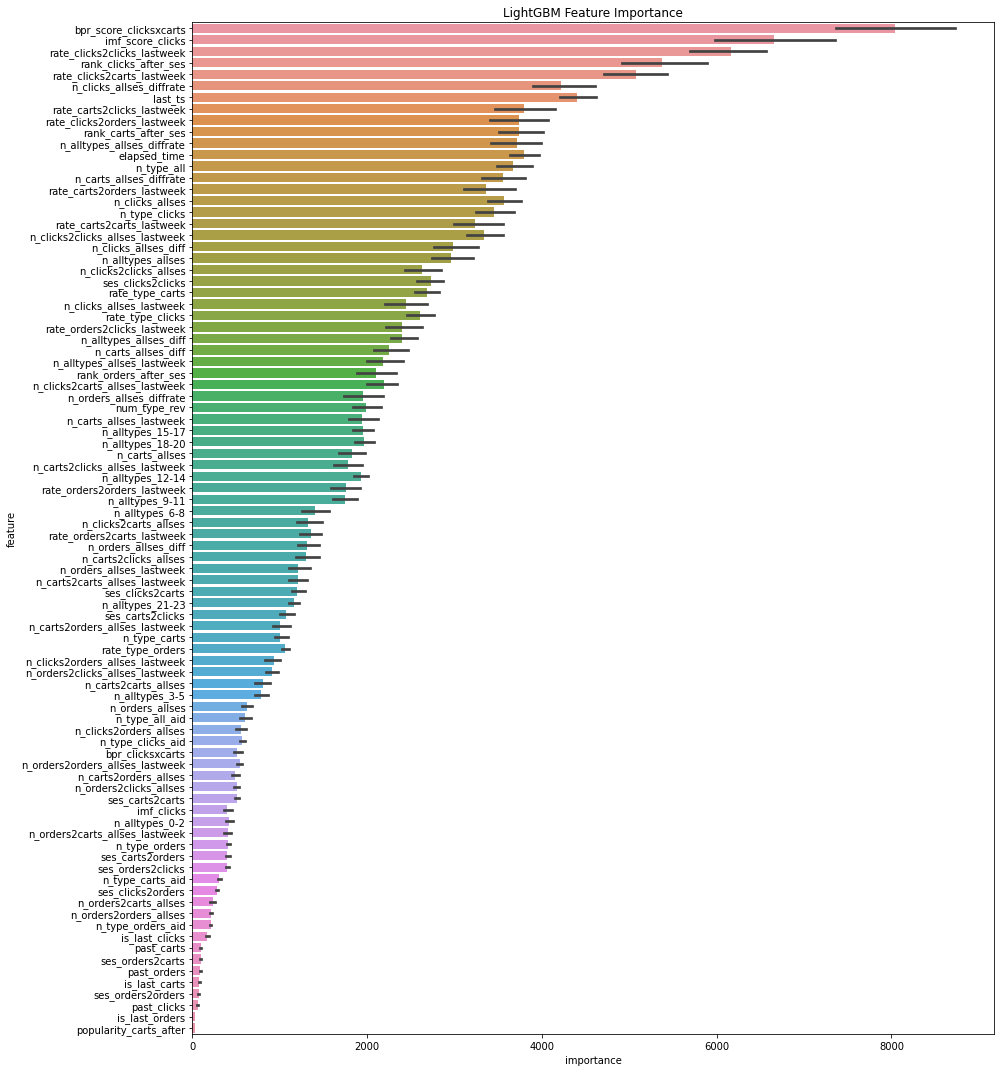

In [10]:
plt.figure(figsize=(14, 15))
sns.barplot(x="importance", y="feature", data=df_fimp.sort_values(by="importance", ascending=False))
plt.title("LightGBM Feature Importance")
plt.tight_layout()